In [1]:
from model import *
from helpers import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from scipy.interpolate import RegularGridInterpolator


In [15]:
def get_first_interglacial_duration(results):
    t = results['t']
    snowball = results['snowball']
    _, _, _, interglacial_durations = get_times(t, snowball)
    if interglacial_durations:
        return interglacial_durations[0]
    return np.nan

def get_last_interglacial_duration(results):
    t = results['t']
    snowball = results['snowball']
    _, _, _, interglacial_durations = get_times(t, snowball)
    if interglacial_durations:
        return interglacial_durations[-1]
    return np.nan

In [5]:
def sweep_grid_first(C_imb_array, tau_array,
                     Cimb_min_guess=0.4,
                     max_t_max=100,
                     dt=1e4/1e6):
    Cimb_min_guess = 0.4
    n_tau = len(tau_array)
    n_c   = len(C_imb_array)
    first_inter_grid = np.full((n_tau, n_c), np.nan, dtype=float)

    for i, tau in enumerate(tau_array):
        for j, C_imb in enumerate(C_imb_array):
            guess_duration = -tau * np.log(Cimb_min_guess / C_imb)
            t_max = guess_duration + 10
            if guess_duration > max_t_max:
                continue
            results = run_model(W_LIP=C_imb, tau=tau, PC_LIP=0, t_max=t_max, dt=dt)
            first_inter_grid[i, j] = get_first_interglacial_duration(results)
    return first_inter_grid

In [11]:
Cimb_arr = np.linspace(1, 40, 30)
tau_arr  = np.linspace(10, 80, 30)
first_inter_grid = sweep_grid_first(Cimb_arr, tau_arr)

In [46]:
# Prepare data for constant-product runs (parallelized; first & last interglacial)
import os
from concurrent.futures import ThreadPoolExecutor
import numpy as np

K_values = [40, 60, 80, 100]

# τ samples to evaluate directly
tau_line = np.linspace(10, 80, 60)

Cimb_min_guess = 0.4
max_t_max = 100
dt = 1e4/1e6

# Worker to evaluate a single (K, tau)
# Imports inside to ensure availability in threads (safe but redundant)

def _evaluate_constant_product(args):
    K, tau, Cimb_min_guess, max_t_max, dt = args
    from model import run_model
    from helpers import get_times
    import numpy as np

    C_imb = K / tau
    guess_duration = -tau * np.log(Cimb_min_guess / C_imb)
    t_max = guess_duration + 10
    if guess_duration > max_t_max:
        return None

    results = run_model(W_LIP=C_imb, tau=tau, PC_LIP=0, t_max=t_max, dt=dt)
    t = results['t']
    snowball = results['snowball']
    _, _, _, interglacial_durations = get_times(t, snowball)
    if interglacial_durations:
        first_dur = interglacial_durations[0]
        if np.isfinite(first_dur):
            return (tau, first_dur)
    return None

# Data structure: list of tuples (K, taus, first_durs)
data = []

for K in K_values:
    print(f"Running constant-product runs for K={K} in parallel...")
    args_list = [(K, tau, Cimb_min_guess, max_t_max, dt) for tau in tau_line]
    taus = []
    first_durs = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as ex:
        for res in ex.map(_evaluate_constant_product, args_list):
            if res is not None:
                tau, first_dur = res
                taus.append(tau)
                first_durs.append(first_dur)
    data.append((K, np.array(taus), np.array(first_durs)))

Running constant-product runs for K=40 in parallel...
Running constant-product runs for K=60 in parallel...
Running constant-product runs for K=80 in parallel...
Running constant-product runs for K=100 in parallel...


/var/folders/sk/pf434pqn61x5nxb3tkpnsxtm0000gp/T/ipykernel_5574/285839571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('cividis')


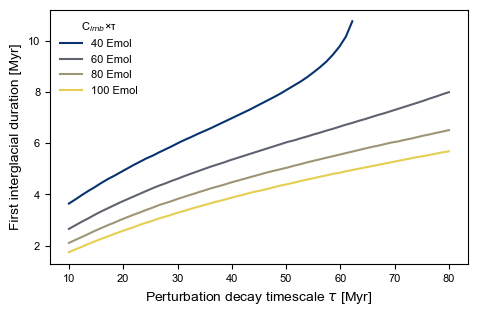

In [47]:
fig = plt.figure(figsize=(4.18, 2.54))
ax = fig.add_axes([0, 0, 1, 1])

cmap = plt.cm.get_cmap('cividis')
colors = [cmap(v) for v in np.linspace(0.1, 0.9, len(data))]

for idx, (K, taus, first_durs) in enumerate(data):
    color = colors[idx % len(colors)]
    if taus.size:
        ax.plot(taus, first_durs, color=color, label=f"{K} Emol")
        #ax.scatter(taus, first_durs, s=20, alpha=0.95, color=color, edgecolors='none')

#ax.set_title("First interglacial vs τ (constant C$_{imb}$×τ)")
ax.set_xlabel("Perturbation decay timescale $\\tau$ [Myr]")
ax.set_ylabel("First interglacial duration [Myr]")
ax.legend(frameon=False, fontsize=8, title="C$_{imb}$×τ")

figname = "indur_tau.pdf"
savefig(fig, figname, savefmt='pdf', supp_folder="supp")
plt.show()